module://ipykernel.pylab.backend_inline
7.500000


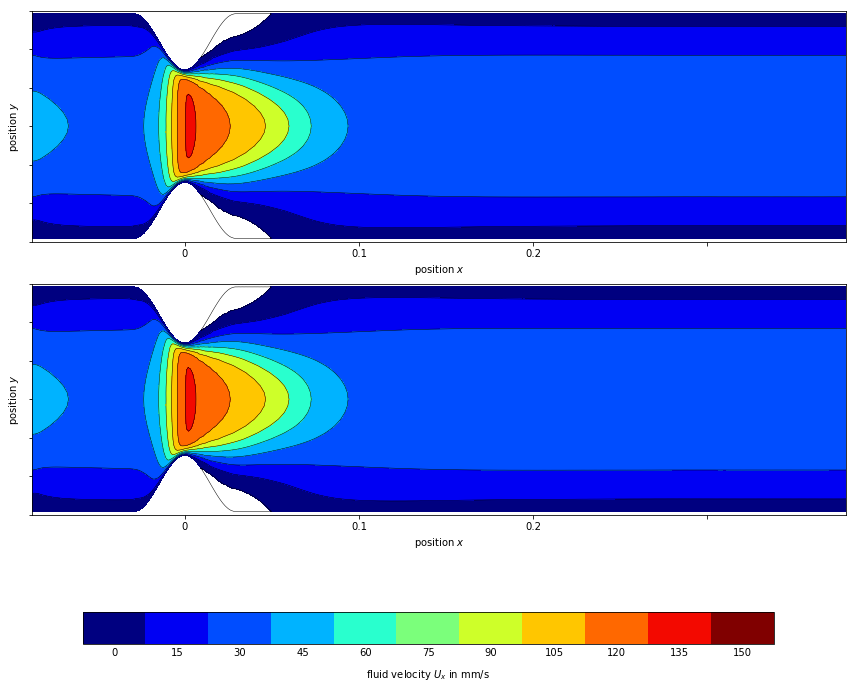

In [ ]:
%matplotlib inline
#!/usr/bin/env python
# import matplotlib
# matplotlib.use('TkAgg')
# import matplotlib.backends.backend_tkagg
import numpy as np
import vtk
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import matplotlib.tri as tria
from matplotlib import colors as clr, cm
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker


def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))


def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)


def load_velocity(filename):
    if not os.path.exists(filename): return None
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.ReadAllVectorsOn()
    reader.Update()

    # create a plane to cut,here it cuts in the XZ direction (xz normal=(1,0,0);XY =(0,0,1),YZ =(0,1,0)
    plane = vtk.vtkPlane()
    plane.SetOrigin(0, 0, 0)
    plane.SetNormal(0, 0, 1)

    # create cutter
    cutter = vtk.vtkCutter()
    cutter.SetCutFunction(plane)
    cutter.SetInputConnection(reader.GetOutputPort())
    cutter.Update()
    # cutterMapper = vtk.vtkPolyDataMapper()
    # cutterMapper.SetInputConnection(cutter.GetOutputPort())

    data = cutter.GetOutput()
    cells = data.GetPolys()
    triangles = cells.GetData()
    points = data.GetPoints()
    point_data = data.GetPointData()
    Udata = point_data.GetArray('U')

    ntri = triangles.GetNumberOfTuples()/4
    npts = points.GetNumberOfPoints()
    nvls = Udata.GetNumberOfTuples()

    tri = np.zeros((int(ntri), 3))
    x = np.zeros(npts)
    y = np.zeros(npts)
    z = np.zeros(npts)
    ux = np.zeros(nvls)
    uy = np.zeros(nvls)
    uz = np.zeros(nvls)

    for i in range(0, int(ntri)):
        tri[i, 0] = triangles.GetTuple(4*i + 1)[0]
        tri[i, 1] = triangles.GetTuple(4*i + 2)[0]
        tri[i, 2] = triangles.GetTuple(4*i + 3)[0]

    for i in range(points.GetNumberOfPoints()):
        pt = points.GetPoint(i)
        x[i] = pt[0]
        y[i] = pt[1]
        z[i] = pt[2]

    for i in range(0, Udata.GetNumberOfTuples()):
        U = Udata.GetTuple(i)
        ux[i] = U[0]
        uy[i] = U[1]
        uz[i] = U[2]

    return x, y, z, tri, ux, uy, uz


def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


print(plt.get_backend())

factor = 1000
upper = 0.15 * factor
lower = 0.0 * factor
N = 11

plt.clf()
levels = np.linspace(lower, upper, N)
x, y, z, tri, ux, uy, uz = load_velocity('RANS_ke_600.vtk')
ux = ux * factor
uy = uy * factor
uz = uz * factor
# fig, ax = plt.subplots(ncols=1, nrows=1)
# fig, (ax1, ax2) = plt.subplots(figsize=(7.48031, 7.48031/2), nrows=2, ncols=1)
fig, (ax1, ax2) = plt.subplots(figsize=(12, 9), nrows=2, ncols=1)
# ax1.set_aspect('equal')


ax1.set_xlabel('position $x$')
ax1.set_ylabel('position $y$')
ax1.set_ylim([-0.015, 0.015])

step = (levels[1]-levels[0]) / 2
print('%f' % step)

name = 'jet'
# define the colormap
cmap = cm.get_cmap(name=name, lut=N)

ax1.tricontour(x, y, tri, ux, levels=levels, linestyles='-',
             colors='black', linewidths=0.5)
cp = ax1.tricontourf(x, y, tri, ux, levels=levels, cmap=cmap)

ax2.tricontour(x, y, tri, ux, levels=levels, linestyles='-',
             colors='black', linewidths=0.5)
ax2.tricontourf(x, y, tri, ux, levels=levels, cmap=cmap)
# ax2.set_aspect('equal')
ax2.set_xlabel('position $x$')
ax2.set_ylabel('position $y$')
ax2.set_ylim([-0.015, 0.015])

norm = clr.Normalize()
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
deltac = (upper-lower)/(2*(N-1))

mapper.set_array(np.linspace(lower-deltac, upper+deltac, 10))  # <-- the 10 here is pretty arbitrary
# clb = fig.colorbar(mapper, shrink=1.0, orientation='horizontal', ticks=levels, format=ticker.FuncFormatter(fmt))
cbar_ax = fig.add_axes([0.1, 0, 0.8, 0.05])
# cbar_ax = fig.add_axes([0, 0, 0.05, 0.5])

# clb = fig.colorbar(mapper, shrink=1.0, orientation='horizontal', ticks=levels, format='%.0f', cax=cbar_ax)
clb = fig.colorbar(mapper, orientation='horizontal', ticks=levels, format='%.0f', cax=cbar_ax)
clb.ax.tick_params(size=0)

if factor == 1000:
    prefix = 'm'
elif factor == 1000000:
    prefix = '$\mu#'
elif factor == 1:
    prefix = ''
else:
    prefix = 'PREFIXERROR'

# clb.ax.set_title('fluid velocity in ' + prefix + 'm/s')
clb.set_label('fluid velocity $U_x$ in ' + prefix + 'm/s', labelpad=10)

# Q = plt.quiver(x[::100], y[::100], ux[::100], uy[::100], scale=2000, scale_units='width', width=0.001)

# plt.minorticks_on()
ax1.set_xticklabels([-0.1, 0, 0.1, 0.2])
ax1.set_yticklabels([])
ax2.set_xticklabels([-0.1, 0, 0.1, 0.2])
ax2.set_yticklabels([])
# plt.title('$U_x$', y=1.08)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
# ax.xaxis.labelpad = 20
# plt.savefig("Ux.png", dpi=300, bbox_inches='tight')
plt.savefig("Ux.pdf", bbox_inches='tight')
# plt.rcParams['figure.figsize'] = (12, 9) # (w, h)
plt.show(block=True)
